# 14-14. 프로젝트: 한국어 데이터로 챗봇 만들기


- import

In [124]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print("슝=3")

슝=3


## Step 1. 데이터 수집하기


한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.  
데이터 다운로드 : https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv




In [125]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Exploration/transformer_chatbot/data/ChatbotData .csv')

In [126]:
data.sample(10)

,Q,A,label
1330,동생이랑 대판 싸움,싸우면서 크는 거죠.,0
3658,이 쓰레기야,욕해 주세요.,0
491,나 무시하는 사람 어떻게 해?,무시하세요.,0
1091,늘 빡빡하게 살기 힘드네,여유가 생기길 바랍니다.,0
3981,잠 잘못 잤나봐,뻐근한가봐요.,0
8360,코 앞이 재회.,마음의 준비를 하세요.,1
7910,장가간 그사람,이젠 잊어버리세요. 미련은 독이 됩니다.,1
3314,오늘 지각인듯 뭐라 그러지,핑계보다 솔직하게 말해보세요.,0
7282,우리서로 애써봐,우리를 위해 같이 애써봐요.,1
583,나는 누구인가,저도 궁금하네요.,0


In [236]:
# 데이터 살펴보기

print("총 샘플의 개수    : {}".format(len(data)))             # 11823
print("결측치의 개수     : {}".format(data.isnull().sum().sum()))   # 결측치 없음
print("레이블 최대값     : {}".format(data['label'].max()))   # 0, 1, 2로 구성; 무슨 의미인지는 모르겠음. (학습에서 제외)

총 샘플의 개수    : 11823
결측치의 개수     : 0
레이블 최대값     : 2


In [128]:
MAX_SAMPLES = 11823

## Step 2. 데이터 전처리하기


영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

- 함수 정의 (데이터 전처리)

In [129]:
'''전처리 함수'''
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)          # 여러 공백을 하나로

    # (가-힣 ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)    # 한국어 전처리
    sentence = sentence.strip()
    return sentence


'''질문, 답변 로드 함수'''
def load_conversations(data):
    inputs, outputs = [], []

    for que, ans in zip(data['Q'],data['A']):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(que))    # 질문
        outputs.append(preprocess_sentence(ans))   # 답변
       
        if len(inputs) >= MAX_SAMPLES:
            return inputs, outputs
        
    return inputs, outputs

In [130]:
#로드한 데이터의 샘플 수를 확인
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(data)
print('전체 질문 샘플 수 :', len(questions))
print('전체 답변 샘플 수 :', len(answers))

전체 질문 샘플 수 : 11823
전체 답변 샘플 수 : 11823


In [131]:
#100번째 샘플을 출력해 질문과 답변이 병렬적으로 잘 저장은 되었는지 확인
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[100]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[100]))

전처리 후의 22번째 질문 샘플: 거지됐어
전처리 후의 22번째 답변 샘플: 밥 사줄 친구를 찾아 보세요


ㄷㄷㄷ...

## Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

- 함수 정의(SubwordTextEncoder)

In [237]:
'''정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩하는 함수'''
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

- 단어장 만들기

In [133]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [134]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [135]:
#시작 토큰과 종료 토큰에 부여된 정수를 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [136]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


 - 단어 정수 인코딩 & 패딩

In [137]:
# 임의의 100번째 샘플에 대해서 정수 인코딩 작업을 수행 (함수 확인)
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[100])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[100])))

정수 인코딩 후의 21번째 질문 샘플: [1940, 460]
정수 인코딩 후의 21번째 답변 샘플: [502, 6943, 7903, 689, 2442, 49]


In [238]:
# 샘플의 최대 허용 단어 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20           # 20 단어로 제한
print(MAX_LENGTH)

20


In [139]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11793
필터링 후의 답변 샘플 개수: 11793


- 교사 강요

In [140]:
BATCH_SIZE = 256
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거합니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기


위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.



##### 준비 함수

In [142]:
'''Positional Encoding'''
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

'''스케일드 닷 프로덕트 어텐션'''
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

'''멀티 헤드 어텐션'''
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

'''패딩 마스킹'''
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

'''룩 어헤드 마스킹'''
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)


##### 인코더 함수

In [143]:
'''인코더 레이어'''
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


'''인코더''' 
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  


##### 디코더 함수

In [144]:
'''디코더 레이어'''
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
'''디코더'''
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

##### 트랜스 포머 함수

In [239]:
'''트랜스포머'''
#앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"
                ):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

##### 손실함수

In [192]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

##### 커스텀 된 학습률(Learning rate)

In [245]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=30):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

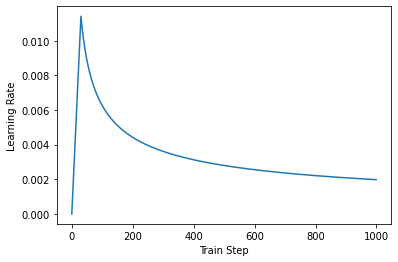

In [246]:
sample_learning_rate = CustomSchedule(d_model=256)

plt.plot(sample_learning_rate(tf.range(1000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

##### Accuracy

In [214]:
# accuracy 함수
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

##### 모델 생성

In [215]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2    # 인코더와 디코더의 층의 개수
D_MODEL = 256     # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8     # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512       # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1     # 드롭아웃의 비율

model = transformer(
                    vocab_size=VOCAB_SIZE
                    , num_layers=NUM_LAYERS
                    , units=UNITS
                    , d_model=D_MODEL
                    , num_heads=NUM_HEADS
                    , dropout=DROPOUT
                    )

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3135232     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

##### 모델 컴파일

In [216]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
                                      learning_rate
                                     , beta_1=0.9
                                     , beta_2=0.98
                                     , epsilon=1e-8
                                     )

model.compile(optimizer=optimizer
              , loss=loss_function
              , metrics=[accuracy]
              )

#### 훈련하기

In [217]:
EPOCHS = 100
es = EarlyStopping(monitor='loss', patience=2, verbose=1)

history = model.fit(dataset, epochs=EPOCHS, callbacks=[es], verbose=1)

Epoch 1/100
47/47 [==============================] - 11s 92ms/step - loss: 2.8791 - accuracy: 0.0441
Epoch 2/100
47/47 [==============================] - 4s 93ms/step - loss: 2.1863 - accuracy: 0.0995
Epoch 3/100
47/47 [==============================] - 4s 93ms/step - loss: 1.8758 - accuracy: 0.1122
Epoch 4/100
47/47 [==============================] - 4s 94ms/step - loss: 1.5991 - accuracy: 0.1350
Epoch 5/100
47/47 [==============================] - 4s 95ms/step - loss: 1.2954 - accuracy: 0.1661
Epoch 6/100
47/47 [==============================] - 4s 95ms/step - loss: 1.0119 - accuracy: 0.1955
Epoch 7/100
47/47 [==============================] - 5s 96ms/step - loss: 0.7558 - accuracy: 0.2263
Epoch 8/100
47/47 [==============================] - 4s 95ms/step - loss: 0.5480 - accuracy: 0.2510
Epoch 9/100
47/47 [==============================] - 4s 95ms/step - loss: 0.3879 - accuracy: 0.2752
Epoch 10/100
47/47 [==============================] - 4s 94ms/step - loss: 0.2667 - accuracy: 0.295

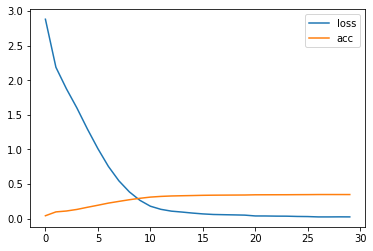

In [218]:
#시각화
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='acc')
plt.legend()
plt.show()

특이하게도 accuracy가 34.9% 정도로 작게 나옴.

## Step 5. 모델 평가하기


Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.




In [219]:
''' 챗봇 테스트하기'''
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


'''임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수'''
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [220]:
#임의의 문장으로부터 챗봇의 대답을 얻어봅시다.
sentence_generation('오늘 점심 뭐 먹어?')

입력 : 오늘 점심 뭐 먹어?
출력 : 건강이 걱정된다고 말해보세요 .


'건강이 걱정된다고 말해보세요 .'

In [247]:
sentence_generation('살찌긴 했어')

입력 : 살찌긴 했어
출력 : 맛있는 거 먹고 기분이 나아졌다면 걱정은 넣어두세요 .


'맛있는 거 먹고 기분이 나아졌다면 걱정은 넣어두세요 .'

In [248]:
sentence_generation('그렇게 말해줘서 고마워.')

입력 : 그렇게 말해줘서 고마워.
출력 : 많이 피곤한가봐요 .


'많이 피곤한가봐요 .'

In [249]:
sentence_generation('응.. 좀 피곤해')

입력 : 응.. 좀 피곤해
출력 : 좀 더 일찍 잠자리에 들어보세요 .


'좀 더 일찍 잠자리에 들어보세요 .'

In [250]:
sentence_generation('그래야겠어')

입력 : 그래야겠어
출력 : 저는 좋아요 .


'저는 좋아요 .'

In [251]:
sentence_generation('암튼 너는 요즘 기분이 어떠니?')

입력 : 암튼 너는 요즘 기분이 어떠니?
출력 : 어떤 선택이든 후회가 남기 마련이지요 .


'어떤 선택이든 후회가 남기 마련이지요 .'

In [252]:
sentence_generation('그래 가지 않은 길은 항상 아쉽긴 해')

입력 : 그래 가지 않은 길은 항상 아쉽긴 해
출력 : 실감이 안날 수 있을 거예요 .


'실감이 안날 수 있을 거예요 .'

In [253]:
sentence_generation('암튼 오늘 반가웠어!')

입력 : 암튼 오늘 반가웠어!
출력 : 그래도 좋아하는 동안 행복하길 바라요 .


'그래도 좋아하는 동안 행복하길 바라요 .'

In [261]:
sentence_generation('고마워~ 안녕.')

입력 : 고마워~ 안녕.
출력 : 감사합니다 .


'감사합니다 .'

## 회고
1. 트렌스포머, 특히 어텐션에 대한 이해를 깊게 할 수 있어 좋았습니다. 
2. 트랜스포머는 시퀀스가 있는 데이터를 예측하는 데 탁월한 성능을 보이는 모델이라도 하는데 약 12000 개의 데이터만 가지고도 비교적 괜찮은 결과를 보이는 점에서 대단하다는 생각이 들었습니다.
3. 아직 정확하게 이해한 것은 아니지만, 앞으로 더 깊이 공부해 보고 싶은 모델입니다. 
4. 처음에 학습률이 낮게 시작해서 그런지 acc가 크게 변하지 않아 학습률을 높이면서 학습을 진행했습니다. 학습 초기 학습률이 0.01을 넘어야 acc가 비교적 높게 나오는 것을 확인할 수 있었습니다. (17% -> 35%로 변화) 이는 초기에 작은 학습률로는 local minimum을 지나 global minimum으로 가는데 어려움이 있지 않았을까하는 생각이 들었습니다.
5. 그럼에도 불구하고 acc는 최대 35%를 넘지 못했습니다. 물론, 결과를 봤을 때 17%나 35%나 챗봇의 대화 능력에 큰 차이가 없는 것처럼 보였지만, 더 좋은 모델을 설계하기 위해서는 acc를 높이는 방향으로 가는 것이 좋을 것 같습니다.
6. 그러기 위해서는 더 많은 샘플 데이터가 필요하고, 정교한 데이터 전처리가 필요해 보입니다. 

  
